In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
import xgboost as xgb

# Portfolio Project - Attacks on Industrial Control Systems (ICS) - Electrical Pipelines
# Model 2 - Gradient Boosting

In [2]:
# Loading the cleansed dataset, with correct types
column_names = pd.read_csv("CleanData/clean_dataset.csv", nrows=0).columns.tolist()
dtype = {col: 'float64' for col in column_names[:-1]}
dtype[column_names[-1]] = 'object'
dataset = pd.read_csv("CleanData/clean_dataset.csv", dtype=dtype)

# Describe the data to make sure we loaded the cleanset dataset properly
dataset.describe()

,R1-PA1:VH,R1-PM1:V,R1-PA2:VH,R1-PM2:V,R1-PA3:VH,R1-PM3:V,R1-PA4:IH,R1-PM4:I,R1-PA5:IH,R1-PM5:I,...,control_panel_log3,control_panel_log4,relay1_log,relay2_log,relay3_log,relay4_log,snort_log1,snort_log2,snort_log3,snort_log4
count,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000,...,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000
mean,-15.802424,130764.039577,2.175196,131035.528095,6.834315,131395.717581,-14.334996,393.949321,3.538540,387.438133,...,0.000026,0.000026,0.035916,0.026436,0.026500,0.035597,0.000051,0.000051,0.000089,0.000077
std,100.876750,8546.118477,111.743169,5393.135370,97.065063,5443.752388,99.601107,190.966011,109.504977,151.277183,...,0.005051,0.005051,0.186082,0.160430,0.160618,0.185285,0.007144,0.007144,0.009450,0.008749
min,-179.988962,0.000000,-179.994691,0.000000,-179.994691,0.000000,-179.994691,0.000000,-179.994691,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-100.416583,131057.982300,-102.129727,130732.029800,-69.459673,131133.202100,-98.159129,305.793700,-94.790138,311.836330,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-28.865614,131684.814000,8.118812,131358.861500,13.401483,131760.033900,-23.514188,378.671480,1.885031,383.249230,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,68.096034,132186.279400,104.897113,131885.400200,85.324875,132261.499300,66.274028,456.676340,102.674037,460.338540,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,179.994691,151592.990400,179.994691,151567.917200,179.988962,151693.283500,179.994691,1779.462980,179.994691,1265.656320,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Slit the dataset into Train and Test set

In [20]:
from sklearn.preprocessing import LabelEncoder

# test_size 0.2 means 20% of the dataset will be sampled, 
# we also use stratify=y to keep the proportions as our dataset is highly imbalanced
train, test = train_test_split(dataset, test_size=0.2, stratify=dataset.marker) 
X_train = train.drop(columns="marker") #drop the marker column
y_train = train.marker #take the marker column
X_test = test.drop(columns="marker")
y_test = test.marker
# Encode labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)  # Fit on training data only
y_test = encoder.fit_transform(y_test)  # Fit on testing data only

### Scale the data
As we can observe in the analysis of the data, the data is not normalized and some columns have values above 100.000, while others are narrowed between 0 and 100, with negative values. 
There is a risk of feature dominance and introducing bias in the model.
We therefore need to scale the data.

Scaling options: min-max normalization and standardization.
Min-max is known to be useful for algorithms sensitive to feature scales (e.g., k-nearest neighbors), while standardization cam be used more in case of regression techniques or neural networks. 
We will therefore go with min-max normalization.

In [14]:
# Only standardize the predictors.
from sklearn.preprocessing import MinMaxScaler

scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)

### Hyperparameters tuning - Baysian Optimization
For this model, we will use XGBoost (Extreme Gradient Boosting) is a powerful machine learning framework for regression and classification tasks. When using the XGBRegressor from XGBoost, we can configure several hyperparameters to fine-tune the model. Due to high computing needs for the size of our dataset, GridSearch or RandomSearch are not convenient for hyperparameters tuning. We will therefore use Bayesian Optimization.
Bayesian optimization trains a machine learning model to predict the best hyperparameters. It is a function optimization: each set of hyperparameters corresponds to a different model performance (e.g., accuracy, AUC). Unlike grid search or random search, Bayesian optimization explores the parameter space systematically and intelligently.

In [7]:
from bayes_opt import BayesianOptimization
from xgboost import XGBClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_val_score

def hyperparam_loss(learning_rate, max_depth, min_child_weight):
    # Initialize XGBoost classifier with hyperparameters
    clf = XGBClassifier(
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        min_child_weight=int(min_child_weight),
        n_estimators=100,  # You can adjust other hyperparameters too
        random_state=42
    )
    # Calculate cross-validated loss (e.g., AUC)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    return scores.mean()  # Return mean AUC

# Define the parameter bounds for Bayesian optimization
pbounds = {
    'learning_rate': (0.01, 0.3),
    'max_depth': (3, 10),
    'min_child_weight': (1, 10)
}

# Initialize Bayesian optimizer
optimizer = BayesianOptimization(
    f=hyperparam_loss,
    pbounds=pbounds,
    random_state=42,
)

# Maximize the objective (minimize negative loss)
optimizer.maximize(init_points=5, n_iter=10)

# Get the best hyperparameters
best_params = optimizer.max['params']
print("Best hyperparameters:", best_params)

|   iter    |  target   | learni... | max_depth | min_ch... |
-------------------------------------------------------------
| 1         | 0.8403    | 0.1186    | 9.655     | 7.588     |
| 2         | 0.7675    | 0.1836    | 4.092     | 2.404     |
| 3         | 0.7888    | 0.02684   | 9.063     | 6.41      |
| 4         | 0.7552    | 0.2153    | 3.144     | 9.729     |
| 5         | 0.7807    | 0.2514    | 4.486     | 2.636     |
| 6         | 0.8702    | 0.1719    | 10.0      | 8.276     |
| 7         | 0.7736    | 0.01      | 9.732     | 9.928     |
| 8         | 0.8816    | 0.3       | 9.234     | 8.432     |
| 9         | 0.8702    | 0.3       | 8.052     | 8.438     |
| 10        | 0.8333    | 0.3       | 6.481     | 7.886     |
| 11        | 0.8528    | 0.3       | 7.082     | 9.704     |
| 12        | 0.9064    | 0.3       | 10.0      | 1.0       |
| 13        | 0.7672    | 0.01      | 8.779     | 1.0       |
| 14        | 0.9064    | 0.3       | 10.0      | 1.74      |
| 15    

### Build and Train the model
We can now build and train the Gradient Boosting model with the hyperparameters found using Bayesian Optimization.

In [21]:
## Build the model 
clf = XGBClassifier(
    learning_rate=0.3,
    max_depth=10,
    min_child_weight=1.0,
    n_estimators=100,  # You can adjust other hyperparameters too
    random_state=42
)
clf.fit(X_train, y_train) 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=1.0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

### Confusion Matrix (Training Set)

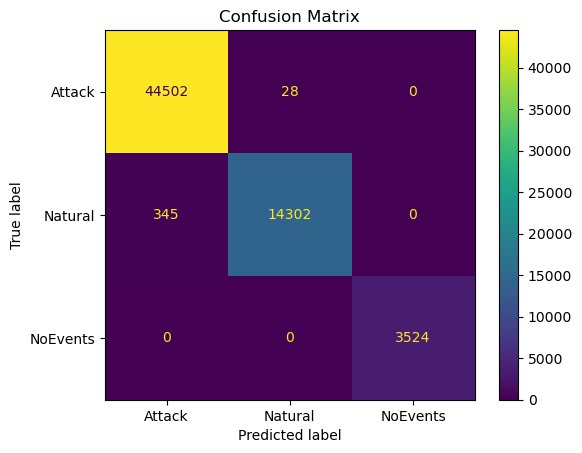

In [22]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = metrics.confusion_matrix(y_train, clf.predict(X_train))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Attack', 'Natural', 'NoEvents'])
cm_display.plot()
plt.title('Confusion Matrix')
plt.show()

### Measure Performance (Test Set)

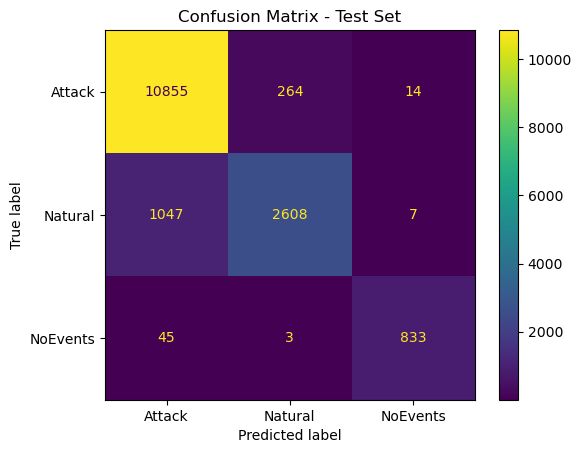

Precision: 0.9304
Recall: 0.8776
F1 Score: 0.8996
Accuracy: 0.91


In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

predict = clf.predict(X_test)
cm = metrics.confusion_matrix(y_test, predict)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Attack', 'Natural', 'NoEvents'])
cm_display.plot()
plt.title('Confusion Matrix - Test Set')
plt.show()

# Compute precision and recall
# Assuming you have true labels (y_true) and predicted labels (y_pred)
precision = precision_score(y_test, predict, average='macro')  # 'macro' for multiclass
recall = recall_score(y_test, predict, average='macro')
f1 = f1_score(y_test, predict, average='macro')
accuracy = accuracy_score(y_test, predict)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.2f}")